# Gradient Boosting
Градиентный бустинг (gradient boosting) — это метод машинного обучения, который позволяет последовательно улучшать качество предсказаний, комбинируя слабые модели (например, решающие деревья) в сильную модель.

Основная идея заключается в том, чтобы обучить новую модель, которая будет исправлять "ошибки" предыдущей модели, постепенно улучшая качество предсказаний на каждой итерации. Это достигается путем нахождения градиента функции потерь (например, MSE или MAE) по отношению к предсказаниям текущего ансамбля моделей и обучения новой модели на этих ошибках. 

В файле [gradientboosting.py](gradientboosting.py) я реализовал шаг за шагом "спускаясь" к минимуму ошибки (функции потерь)


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn import ensemble
from sklearn.metrics import mean_squared_error, mean_absolute_error
import gradientboosting


## Подготовим данные 
Будем использовать датасет с кредитными заявками прошлых периодов.\
`delay_days` - таргет

In [21]:
df = pd.read_csv('users.csv')

In [22]:
X = df.drop('delay_days', axis=1)

In [23]:
X.head(3)

,age,income,dependents,has_property,has_car,credit_score,job_tenure,has_education,loan_amount,loan_period
0,76,32181,3,0,1,814,28,1,142434,1770
1,69,52789,8,1,0,501,28,1,120887,1590
2,19,70535,1,0,1,325,26,1,188766,810


`age` – возраст клиента,\
`income` — месячный доход,\
`dependents` – количество зависимых членов семьи,\
`has_property` – наличие недвижимости,\
`has_car` – наличие автомобиля,\
`credit_score` – кредитный рейтинг,\
`job_tenure` – срок работы на текущем месте (лет)\
`has_education` – образование (0 - нет, 1 - да),\
`loan_amount` – сумма кредита,\
`loan_period` – срок кредита в днях по договору,\
`delay_days` – количество дней просрочки (__целевая переменная__).

In [24]:
y = df['delay_days']

Разделим данные на тренировочную и тестовую части.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Метрики ошибок
MSE (средняя квадратическая ошибка) — это оценка среднего значения квадрата ошибок, различие между предсказанием и фактическим значением. Эту метрику удобно использовать для выявления аномалий.\
MAE (средняя абсолютная ошибка) — это оценка того, насколько близки предсказания к фактическим значениями

__Реализую их вручную по формулам__

In [26]:
def mse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Mean squared error loss."""
    return float(np.mean((y_pred - y_true) ** 2))


def mae(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Mean absolute error loss."""
    return float(np.mean(np.abs(y_pred - y_true)))


Создадим модель и обучим под наши данные

In [27]:
model_manual = gradientboosting.GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_samples_split=2,
    loss='mse',
    verbose=False,
)

In [28]:
model_manual.fit(X_train, y_train)

Предсказываем данные и расчитываем метрики MSE и MAE

In [29]:
y_pred_manual = model_manual.predict(X_test)

In [30]:
mae_manual = mae(y_test, y_pred_manual)
mse_manual = mse(y_test, y_pred_manual)

### Сравнение с `sklearn`

In [31]:
# Параметры передаем аналогичные
model_sklearn = ensemble.GradientBoostingRegressor(
    n_estimators=100,
    max_depth=3,
    min_samples_split=2,
    learning_rate=0.1,
    loss="squared_error",
)


In [32]:
# Обучим на тех же данных
model_sklearn.fit(X_train, y_train)

,loss,'squared_error'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [33]:
# Предсказываем целевое значение
y_pred_sklearn = model_sklearn.predict(X_test)

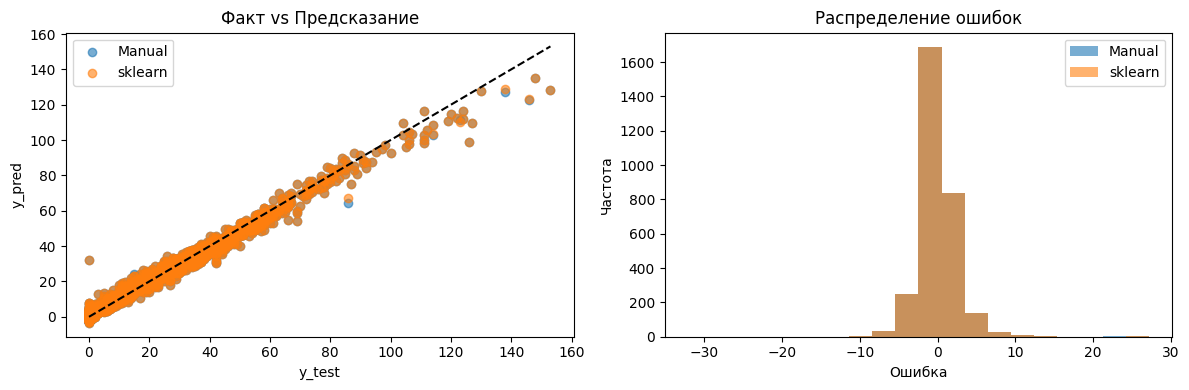

In [34]:
# Визуальное сравнение предсказаний и ошибок
residuals_manual = y_test - y_pred_manual
residuals_sklearn = y_test - y_pred_sklearn

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].scatter(y_test, y_pred_manual, alpha=0.6, label='Manual')
axes[0].scatter(y_test, y_pred_sklearn, alpha=0.6, label='sklearn')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
axes[0].set_title('Факт vs Предсказание')
axes[0].set_xlabel('y_test')
axes[0].set_ylabel('y_pred')
axes[0].legend()

axes[1].hist(residuals_manual, bins=20, alpha=0.6, label='Manual')
axes[1].hist(residuals_sklearn, bins=20, alpha=0.6, label='sklearn')
axes[1].set_title('Распределение ошибок')
axes[1].set_xlabel('Ошибка')
axes[1].set_ylabel('Частота')
axes[1].legend()

plt.tight_layout()
plt.show()


In [35]:
mse_sklearn = mse(y_test, y_pred_sklearn)
mae_sklearn = mae(y_test, y_pred_sklearn)

In [36]:
print('Расчет метрик:')
print(f'MSE ручной расчет: {mse_manual}\n'
      f'MAE ручной расчет: {mae_manual}\n'
      f'MSE в sklearn: {mse_sklearn}\n'
      f'MAE в sklearn: {mae_sklearn}\n')

Расчет метрик:
MSE ручной расчет: 6.411072398308036
MAE ручной расчет: 1.614080900001554
MSE в sklearn: 6.3630372077952035
MAE в sklearn: 1.612627130784991



Для убедительности сравним метрики наших моделей с расчетами в\
`sklearn.metrics` `mean_squared_error` и `mean_absolute_error`

In [37]:
mse_sk = mean_squared_error(y_test, y_pred_sklearn)
mae_sk = mean_absolute_error(y_test, y_pred_sklearn)
mse_man = mean_squared_error(y_test, y_pred_manual)
mae_man = mean_absolute_error(y_test, y_pred_manual)

In [38]:
print('Расчет метрик в sklearn:')
print(f'MSE ручной расчет: {mse_man}\n'
      f'MAE ручной расчет: {mae_man}\n'
      f'MSE в sklearn: {mse_sk}\n'
      f'MAE в sklearn: {mae_sk}\n')

Расчет метрик в sklearn:
MSE ручной расчет: 6.411072398308036
MAE ручной расчет: 1.614080900001554
MSE в sklearn: 6.3630372077952035
MAE в sklearn: 1.612627130784991



In [48]:
abs(mse_manual - mse_sklearn)

0.04803519051283267

In [49]:
abs(mae_manual - mae_sklearn)

0.0014537692165628169

## Анализ результатов

Предсказания кастомной реализации и `sklearn.GradientBoostingRegressor`
не совпадают бит-в-бит, что ожидаемо из-за различий в выборе порогов,
порядке вычислений и численных эффектов.

При этом значения метрик (MSE, MAE) отличаются незначительно,
что подтверждает эквивалентность реализованного алгоритма.
